# 1. Data Load

In [1]:
import numpy as np
import pandas as pd

from scipy import stats #Analysis 
from scipy.stats import norm # Analysis
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams
%matplotlib inline
#%matplotlib tk

#import matplotlib 
#matplotlib.font_manager._rebuild()

In [2]:
# 한글 폰트가 깨지면 실행하세요! 
import matplotlib.font_manager as fm
fontlist = fm.findSystemFonts(fontpaths = None, fontext='ttf')
# 아래 주석을 지워서 폰트 리스트를 확인하고 한글 폰트를 font_path에 추가합니다
fontlist[:]

from matplotlib import font_manager, rc
#font_path = 'C:\\Users\\mtang\\AppData\\Local\\Microsoft\\Windows\\Fonts\\NanumSquare.ttf'
font_path = 'C:\\WINDOWS\\Fonts\\NanumGothicLight.ttf'
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)

In [3]:
path = "./Dataset/"

data = pd.read_csv(path+"kwproja_data_big.csv")
data.head() # original data -> data

,date,shop_code,shop_name,shop_type_big,shop_type_small,longitude,latitude,monthly_gain,average_sale_price
0,201709,24432350113,친쿡부대찌개 오류동본점,뷔페,고기 뷔페,126.844998,37.496882,12881013.37,21514
1,201709,13141330215,드럼통집,뷔페,고기 뷔페,127.096574,37.505706,33931612.72,52264
2,201706,39421720107,하우돈,뷔페,고기 뷔페,126.906290,37.518280,21456513.16,42656
3,201706,4602500509,고고생고기,뷔페,고기 뷔페,127.109240,37.501153,6140707.30,34561
4,201709,39313780106,현대식당,뷔페,고기 뷔페,126.980601,37.518535,6091482.50,38423


# EDA 

2,927,739 rows X 9 columns

- 매장 속성 정보
  - shop_code -> 식별자 feature, input feature로는 사용하지 않지만 분류를 위해서는 사용할 수 있을 것 같음  
  - shop_name -> input feature로는 사용하지 않음 (NLP deep learning 가능성 있음)
  - longtitude : 경도, latitude : 위도 -> 매장 위치 (회사 근처, 학교 근처 등 매출 영향성 있음) -> 군집화, labeling 필요
  - shop_type_big -> 15 category  -> 업종 (매출 영향성 있음)
  - shop_type_small -> 61 category

- 매출 정보
  - date -> 24 category, 201606~ 201805 까지의 data
  - monthly_gain / avearge_sale_price = 한달 총 판매수

- 매출 통계 정보-> X


##### monthly_gain과 average_sale_price 중 어느 것을 y값으로 둘 것인가? 
- 월매출 예측 문제로 가정하고 montly_gain 을 y값으로 예측하는 모델 만들기

##### shop_code는 input feature에 넣어야 하는가?
- 특별한 브랜드가 y값을 결정하는 과적합 요소가 될 수 있으므로
- X 에서 shop code, shop name 제외하는 것도 방법
- 어느 위치에 어떤 업종으로 어떤 객단가인 매장을 오픈하면 월매출이 어떻게 될까? 문제
 - X: shop type big, shop type small, longitude, latitude, avg_sale_price, 
 - y: montly_gain

In [4]:
data.columns

Index(['date', 'shop_code', 'shop_name', 'shop_type_big', 'shop_type_small',
       'longitude', 'latitude', 'monthly_gain', 'average_sale_price'],
      dtype='object')

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2927739 entries, 0 to 2927738
Data columns (total 9 columns):
 #   Column              Dtype  
---  ------              -----  
 0   date                int64  
 1   shop_code           int64  
 2   shop_name           object 
 3   shop_type_big       object 
 4   shop_type_small     object 
 5   longitude           float64
 6   latitude            float64
 7   monthly_gain        float64
 8   average_sale_price  int64  
dtypes: float64(3), int64(3), object(3)
memory usage: 201.0+ MB


# 3. Preprocessing
- missing value 제거 
    - monthly_gain : 3,605 제거 -> 149,790
    - shop_type_big : 4,303 제거 -> 145,487 
    - gender feature : 1,187 제거 -> 144,300
- shop_code, shop_name : 식별자 feature 이므로 drop 
- date : 아직은 쓸 수 없으므로 drop
    - 여기까지 총 144,300 X 27
- shop_type_big(13), shop_type_small(367) : label encodding
- longitude, latitude : clustering을 통해 labeling 후 해당 두 열은 drop 
- MinMaxSaclar 정규화 -> 정규화 column의 범위는??

In [4]:
# 원본 data와 따로 관리 -> original data = data, input data = input_data 
# feature drop
input_data = data.copy()
input_data = input_data.drop(['date', 'shop_code', 'shop_name'], axis=1)

In [5]:
# There are no missing values 
# missing value drop - monthly_gain
null_index = input_data[input_data['monthly_gain']==0].index 
print(len(null_index)) 
input_data = input_data.drop(null_index)

# missing value drop - shop_type_big
null_index = input_data[input_data['shop_type_big'].isnull()==True].index
input_data = input_data.drop(null_index)

# There is no "null" in "shop_type_small" feature 
print(len(input_data['shop_type_small'].unique()))
print(input_data['shop_type_small'].isnull().value_counts())

0
61
False    2927739
Name: shop_type_small, dtype: int64


In [6]:
# LabelEncoder
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
input_data['shop_type_big'] = le.fit_transform(list(input_data['shop_type_big']))   # fit transform으로 한번에 처리 가능
#le.classes_

le = LabelEncoder()
input_data['shop_type_small'] = le.fit_transform(list(input_data['shop_type_small'])) 
#le.classes_

[[ 37.49492344 126.8966939 ]
 [ 37.57103151 127.06669312]
 [ 37.51707026 127.12106877]
 [ 37.63891691 127.04523339]
 [ 37.53984087 126.84569152]
 [ 37.5656363  126.99347217]
 [ 37.49648217 126.95202194]
 [ 37.50144528 127.0345241 ]
 [ 37.57405364 126.92448632]]
[4 2 0 ... 1 2 0]


C:\Users\Hyeongbin\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


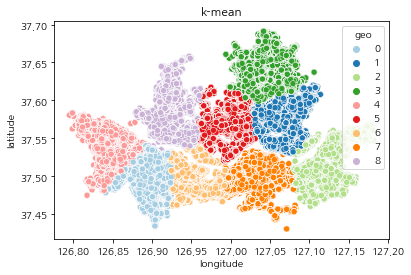

In [7]:
# Labeling - KMeans Clustering 
# longitude + latitude = geo 
# So we get inpute_data = 144,300 X 27
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=9).fit(input_data[['latitude', 'longitude']])
print(kmeans.cluster_centers_)
print(kmeans.labels_)

# longitude + latitude = geo 
# So we get inpute_data = 2,927,739 rows × 5 columns
input_data['geo'] = kmeans.labels_

sns.scatterplot(x='longitude' , y='latitude', hue="geo", data=input_data, palette="Paired")
plt.title('k-mean')

input_data = input_data.drop(['longitude', 'latitude'], axis=1)

In [8]:
# average_sale_price -> skewed 된 feature 
# log정규화 
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler, Normalizer

scale_cols = ['average_sale_price']

for _ in scale_cols : 
    scaled_data = pd.DataFrame(np.log1p(input_data[_]))
    input_data[_] = scaled_data

input_data

,shop_type_big,shop_type_small,monthly_gain,average_sale_price,geo
0,3,0,12881013.37,9.976506,4
1,3,0,33931612.72,10.864082,2
2,3,0,21456513.16,10.660947,0
3,3,0,6140707.30,10.450510,2
4,3,0,6091482.50,10.556438,6
...,...,...,...,...,...
2927734,6,60,13693767.90,9.976366,6
2927735,6,60,17432801.29,11.219359,1
2927736,6,60,17023101.74,10.440361,1
2927737,6,60,31533908.77,10.877557,2


<AxesSubplot:xlabel='shop_type_big', ylabel='average_sale_price'>

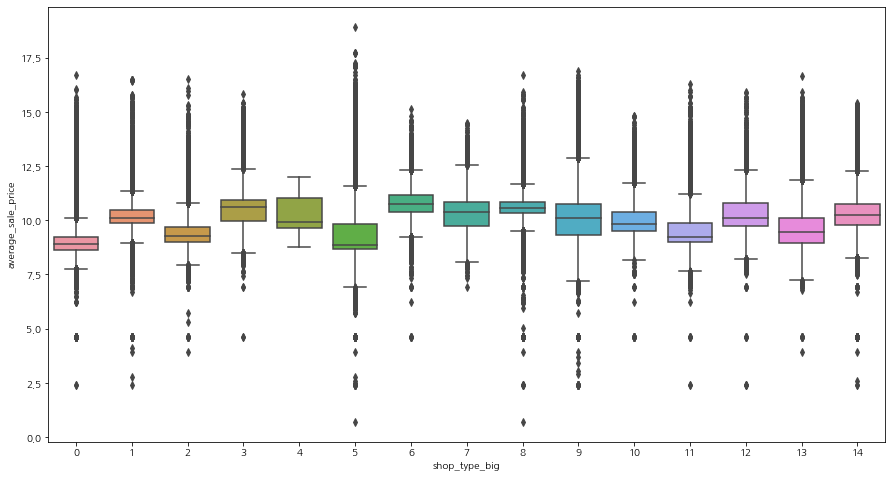

In [9]:
rcParams['figure.figsize'] = 15,8
sns.boxplot(x='shop_type_big', y='average_sale_price', data=input_data)

C:\Users\Hyeongbin\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


2.528132e+05    67
2.482178e+05    64
2.530473e+05    63
2.513737e+05    63
2.533015e+05    62
                ..
2.761393e+06     1
1.998409e+06     1
2.776185e+06     1
2.392145e+08     1
3.399279e+07     1
Name: monthly_gain, Length: 2863443, dtype: int64


C:\Users\Hyeongbin\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\Hyeongbin\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


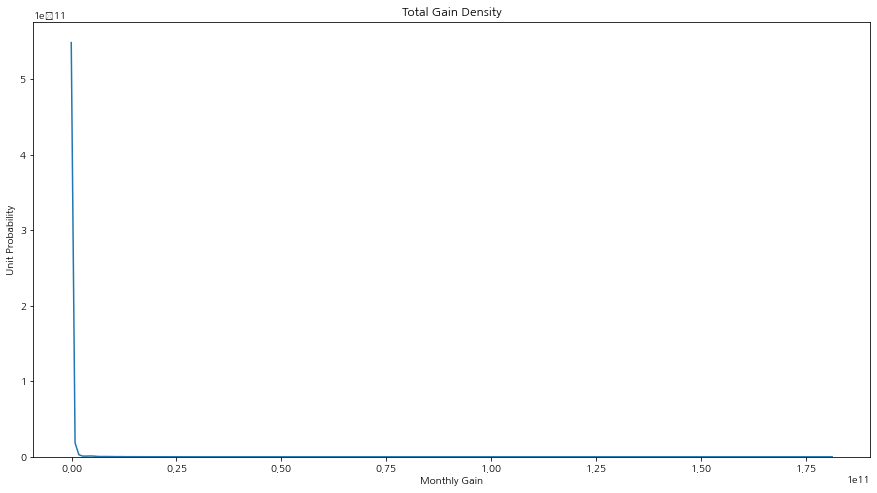

In [10]:
ax = plt.subplots()
ax = sns.distplot(input_data['monthly_gain'], hist=False)
ax.set_title('Total Gain Density')
ax.set_xlabel('Monthly Gain')
ax.set_ylabel('Unit Probability')
print(input_data['monthly_gain'].value_counts())

# 4. 타겟변수 확인
why(or when) to use log transform in ML? 
- target variable이 non-negative values 일때만 
- outlier 값들도 사용해야 하는 경우, outliers that can't be filtered out as they are important to the model.
- 현재 주어진 data도 좌측으로 치우쳐진 (right skewed) 형태, 굉장히 극소수의 업종들만이 굉장히 큰 매출을 만들어낼 수 있는 것으로 보임 
- 어떤 column, feature가 가장 monthly_gain과 상관관계가 높을까요? 
- kaggle house price prediction 대회에서도 RMSE가 아닌 RMSLE를 사용함 -> log를 씌운 형태인데 target variable인 집값의 범위가 넒기 때문

- Skewness: The longer the right tail, the more positive the tail
- Kurtosis (kurtosis / kurtosis): If the kurtosis value (K) is close to 3, the scatter is close to the normal distribution. (K <3), the distributions can be judged to be flattened more smoothly than the normal distribution, and if the kurtosis is a positive number larger than 3 (K> 3), the distribution can be considered to be a more pointed distribution than the normal distribution

In [11]:
print("Skewness: %f" % input_data['monthly_gain'].skew())
print("Kurtosis: %f" % input_data['monthly_gain'].kurt())

Skewness: 165.584485
Kurtosis: 37638.372288


C:\Users\Hyeongbin\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Hyeongbin\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Hyeongbin\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` 

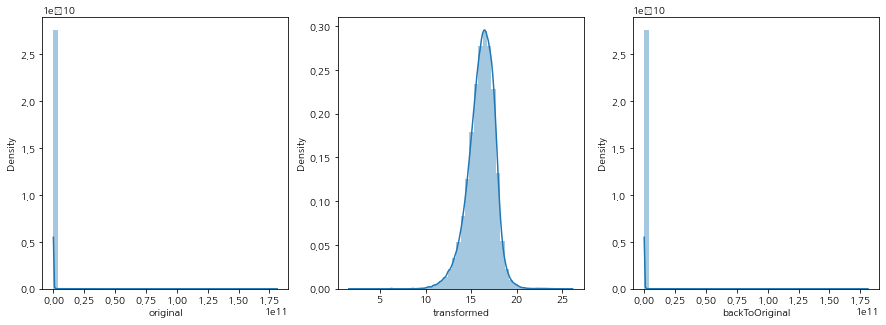

In [12]:
plots=pd.DataFrame()
plots['original']=input_data['monthly_gain']
plots['transformed']=np.log1p(input_data['monthly_gain'])
plots['backToOriginal']=np.expm1(np.log1p(input_data['monthly_gain']))

fig, ax = plt.subplots(1,3,figsize=(15,5))
sns.distplot(plots['original'], ax=ax[0]);
sns.distplot(plots['transformed'], ax=ax[1]);
sns.distplot(plots['backToOriginal'], ax=ax[2]);

C:\Users\Hyeongbin\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\Hyeongbin\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


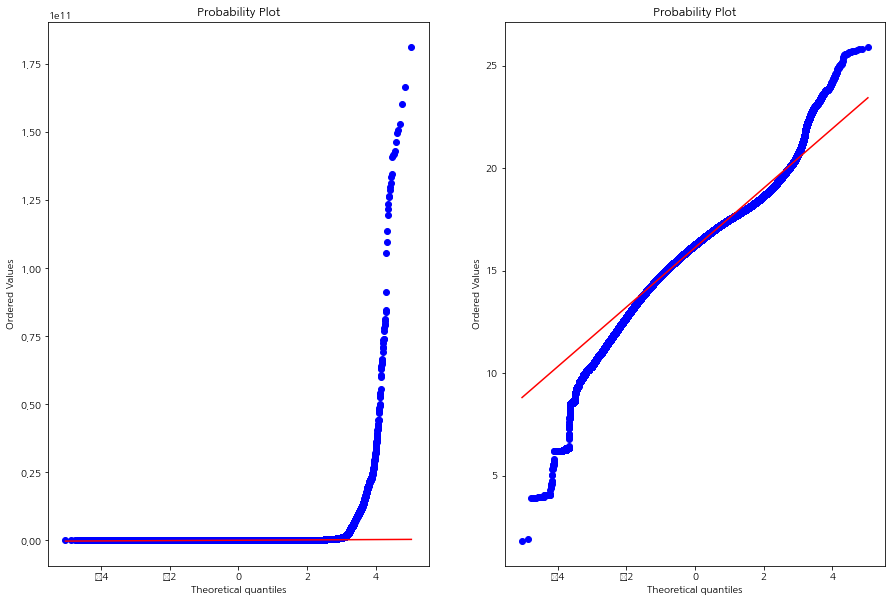

In [13]:
fig = plt.figure(figsize = (15,10))

fig.add_subplot(1,2,1)
res = stats.probplot(input_data['monthly_gain'], plot=plt)

fig.add_subplot(1,2,2)
res = stats.probplot(np.log1p(input_data['monthly_gain']), plot=plt)

# 5. Modeling
- XGB
    - 타겟변수 정규화 실행 
- LGBM
    - loss parameter : tweedie 
- K-Fold Cross Validation (k=5)

In [14]:
# pandas option 설정 하는 코드
# monthly_gain의 경우 부동소수점으로 나타나서 보기 어려울땐 윗 줄의 주석을 제거하고 아래에 주석을 추가하고
# 다시 원래대로 돌리고 싶다면 아래에 주석제거, 위에 주석추가
pd.options.display.float_format = '{:.2f}'.format
#pd.reset_option('display.float_format')

input_data.head()

,shop_type_big,shop_type_small,monthly_gain,average_sale_price,geo
0,3,0,12881013.37,9.98,4
1,3,0,33931612.72,10.86,2
2,3,0,21456513.16,10.66,0
3,3,0,6140707.30,10.45,2
4,3,0,6091482.50,10.56,6


In [135]:
input_data_y = input_data['monthly_gain'].copy()
input_data_X = input_data.drop(['monthly_gain'], axis=1)

In [136]:
from sklearn.model_selection import train_test_split, cross_validate, KFold, TimeSeriesSplit,GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from keras.callbacks import EarlyStopping, ModelCheckpoint

from lightgbm import LGBMRegressor
from lightgbm import plot_importance 
from xgboost import XGBRegressor
from xgboost import plot_importance

In [137]:
model_xgb = XGBRegressor()
model_lgbm = LGBMRegressor()

In [138]:
train_X, test_X, train_y, test_y = train_test_split(
    input_data_X, 
    input_data_y, 
    test_size = 0.2,      
    shuffle=True)  

In [139]:
kfold = KFold(n_splits=5, shuffle=True, random_state = 7)
cv_accuracy = []
n_iter =0

for train_index, valid_index in kfold.split(train_X):  # 데이터를 kfold = 5 로 분할
    x_train, x_valid = train_X.iloc[list(train_index)], train_X.iloc[list(valid_index)]
    y_train, y_valid = train_y.iloc[list(train_index)], train_y.iloc[list(valid_index)]
    #y_train, y_valid = np.log1p(y_train), np.log1p(y_valid)

    model_xgb.fit(x_train, y_train)
    pred = model_xgb.predict(x_valid)
    n_iter += 1
    
    mse = np.round(mean_squared_error(y_valid, pred), 4) # 소수점 4자리 반올림
    rmse = np.sqrt(mse)
    train_size = x_train.shape[0]
    test_size = x_valid.shape[0]
    
    print('\n#{0} 교차 검증 rmse : {1},  학습 데이터 크기 : {2},  검증 데이터 크기 : {3}'
          .format(n_iter, rmse, train_size, test_size))
    print('#{0} 검증 세트 인덱스 : {1}'.format(n_iter,valid_index))
    cv_accuracy.append(rmse)
    
print('\n## 평균 검증 rmse:', np.mean(cv_accuracy))


#1 교차 검증 rmse : 258593442.11968774,  학습 데이터 크기 : 1873752,  검증 데이터 크기 : 468439
#1 검증 세트 인덱스 : [      1       3       8 ... 2342187 2342189 2342190]

#2 교차 검증 rmse : 419840982.9316645,  학습 데이터 크기 : 1873753,  검증 데이터 크기 : 468438
#2 검증 세트 인덱스 : [      4       6      10 ... 2342167 2342169 2342171]

#3 교차 검증 rmse : 335082805.91884065,  학습 데이터 크기 : 1873753,  검증 데이터 크기 : 468438
#3 검증 세트 인덱스 : [     20      21      24 ... 2342172 2342184 2342188]

#4 교차 검증 rmse : 387030355.3505782,  학습 데이터 크기 : 1873753,  검증 데이터 크기 : 468438
#4 검증 세트 인덱스 : [      0       5       9 ... 2342166 2342170 2342174]

#5 교차 검증 rmse : 387729894.72671723,  학습 데이터 크기 : 1873753,  검증 데이터 크기 : 468438
#5 검증 세트 인덱스 : [      2       7      13 ... 2342178 2342180 2342185]

## 평균 검증 rmse: 357655496.2094977


In [140]:
kfold = KFold(n_splits=5, shuffle=True, random_state = 7)
cv_accuracy = []
n_iter =0

for train_index, valid_index in kfold.split(train_X):  # 데이터를 kfold = 5 로 분할
    x_train, x_valid = train_X.iloc[list(train_index)], train_X.iloc[list(valid_index)]
    y_train, y_valid = train_y.iloc[list(train_index)], train_y.iloc[list(valid_index)]
    #y_train, y_valid = np.log1p(y_train), np.log1p(y_valid)
    
    model_lgbm.fit(x_train, y_train)
    pred = model_lgbm.predict(x_valid)
    n_iter += 1
    
    mse = np.round(mean_squared_error(y_valid, pred), 4) # 소수점 4자리 반올림
    rmse = np.sqrt(mse)
    train_size = x_train.shape[0]
    test_size = x_valid.shape[0]
    
    print('\n#{0} 교차 검증 rmse : {1},  학습 데이터 크기 : {2},  검증 데이터 크기 : {3}'
          .format(n_iter, rmse, train_size, test_size))
    print('#{0} 검증 세트 인덱스 : {1}'.format(n_iter,valid_index))
    cv_accuracy.append(rmse)
    
print('\n## 평균 검증 rmse:', np.mean(cv_accuracy))


#1 교차 검증 rmse : 250479285.73029324,  학습 데이터 크기 : 1873752,  검증 데이터 크기 : 468439
#1 검증 세트 인덱스 : [      1       3       8 ... 2342187 2342189 2342190]

#2 교차 검증 rmse : 397541086.28968275,  학습 데이터 크기 : 1873753,  검증 데이터 크기 : 468438
#2 검증 세트 인덱스 : [      4       6      10 ... 2342167 2342169 2342171]

#3 교차 검증 rmse : 329490486.64537495,  학습 데이터 크기 : 1873753,  검증 데이터 크기 : 468438
#3 검증 세트 인덱스 : [     20      21      24 ... 2342172 2342184 2342188]

#4 교차 검증 rmse : 360514994.7490208,  학습 데이터 크기 : 1873753,  검증 데이터 크기 : 468438
#4 검증 세트 인덱스 : [      0       5       9 ... 2342166 2342170 2342174]

#5 교차 검증 rmse : 395595142.37499857,  학습 데이터 크기 : 1873753,  검증 데이터 크기 : 468438
#5 검증 세트 인덱스 : [      2       7      13 ... 2342178 2342180 2342185]

## 평균 검증 rmse: 346724199.15787405


In [141]:
pred_xgb = model_xgb.predict(test_X)
pred_lgbm = model_lgbm.predict(test_X)

In [127]:
#pred_xgb = np.exp(pred_xgb)-1
#pred_lgbm = np.exp(pred_lgbm)-1

#test_y = np.exp(test_y)-1

## Prediction

In [128]:
def plot_history(history):
    #hist = pd.DataFrame(history.history)
    #history['epoch'] = history.epoch
    
    plt.figure(figsize=(8,12))
    
    # Mean Abs Error : 평균 절대 오차, 측정값에서 오차의 크기로 측정값과 실제값과의 차이, 절대 오차의 평균  
    # -> 측정하고자 하는 값을 정확하게 측정하지 못함으로써 발생
    plt.subplot(2,1,1)
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error')
    plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
    plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
    plt.legend()
    
    # Mean Square Error : 평균 제곱 오차, 오차의 제복에 대한 평균을 취한 값
    plt.subplot(2,1,2)
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error')
    plt.plot(hist['epoch'], hist['mse'],
           label='Train Error')
    plt.plot(hist['epoch'], hist['val_mse'],
           label = 'Val Error')
    plt.legend()
    plt.show()
    
def show_pred(test_y, pred) :
    true_y = test_y.to_numpy()
    true_y = np.ravel(true_y)
    
    df_result = pd.DataFrame(list(zip(true_y, pred)), columns=['true_y', 'prediction'])
    return df_result

def show_mse_rmse(test_y, pred) :
    mse = mean_squared_error(test_y, pred)
    print("mse : %f" % mse)
    
    rmse = np.sqrt(mse)
    print("rmse: %f \n" %rmse)

def show_r2_score(test_y, pred, test_X) : 
    r2 = r2_score(pred, test_y)
    print("r2 : %f " % r2)
    
    # 독립변수가 많을 수록 결정계수 r2 값은 커지므로, 독립변수가 2개 이상일 경우 조정된 결정계수 adj_r2를 사용
    # 기존의 결정계수 r2에 n(데이터 개수) 와 k(변수 개수)가 추가 됨 
    # r2 score는 regression model의 훌륭한 평가 지표이지만, 예측 모델과 실제 모델의 분산이 얼마나 비슷한지에 기반하기에 
    # 예측값과 실제값이 많이 달라도 분산만 비슷하면 높은 점수를 얻을 수 있다는 맹점이 있다 
    adj_r2 = 1 - (1-r2)*(test_X.shape[0]-1)/(test_X.shape[0]-test_X.shape[1]-1)
    print("adj_r2_score : %f \n" % adj_r2)
    
def show_prediction_error(test_y, pred) :
    true_y = test_y.to_numpy()
    true_y = np.ravel(true_y)
    error = pred - true_y
    plt.hist(error, bins=25)
    plt.xlabel("Prediction Error")
    _ = plt.ylabel("Count")
    
def feature_importance(model_xgb) : 
    %matplotlib inline
    plt.rcParams['axes.unicode_minus'] = False
    font_path = "C:/Windows/Fonts/NGULIM.TTF"
    font = fm.FontProperties(fname=font_path).get_name()
    rc('font', family=font)

    fig, ax = plt.subplots(figsize=(10,12))
    plot_importance(model_xgb, ax=ax)
    
def graph(pred, test_label) :
    plt.figure(figsize=(16, 9))
    plt.plot(test_label, label = 'actual')
    plt.plot(pred, label = 'prediction')
    plt.legend()
    plt.show()

In [142]:
show_pred(test_y, pred_xgb)

,true_y,prediction
0,22486334.35,13162264.00
1,915427.08,7900095.50
2,394536.21,12034320.00
3,1194660.12,7134517.50
4,22963123.83,17257900.00
...,...,...
585543,13764601.34,17976464.00
585544,10465260.97,41795132.00
585545,28124620.88,15430556.00
585546,10995326.32,-97819592.00


In [143]:
show_pred(test_y, pred_lgbm)

,true_y,prediction
0,22486334.35,14319187.98
1,915427.08,15924580.22
2,394536.21,19184145.02
3,1194660.12,10060603.40
4,22963123.83,28529389.85
...,...,...
585543,13764601.34,21591302.90
585544,10465260.97,34243904.41
585545,28124620.88,20654093.94
585546,10995326.32,27574915.16


In [144]:
show_mse_rmse(test_y, pred_xgb)
show_r2_score(test_y, pred_xgb, test_X)

mse : 133212251803060304.000000
rmse: 364982536.298739 

r2 : 0.340707 
adj_r2_score : 0.340702 



In [145]:
show_mse_rmse(test_y, pred_lgbm)
show_r2_score(test_y, pred_lgbm, test_X)

mse : 134758610603073824.000000
rmse: 367094825.083484 

r2 : 0.349497 
adj_r2_score : 0.349492 



C:\Users\Hyeongbin\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\Hyeongbin\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


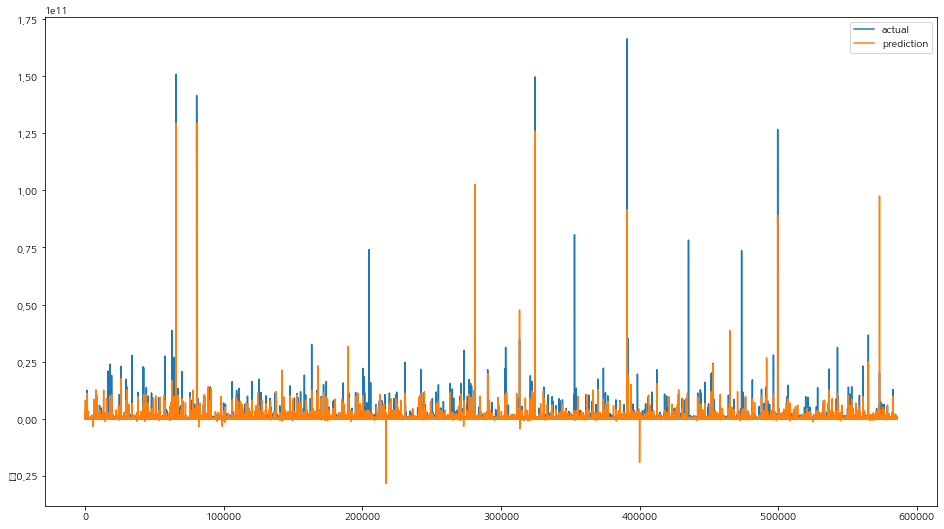

In [146]:
true_y = test_y.to_numpy()
graph(pred_xgb, true_y)

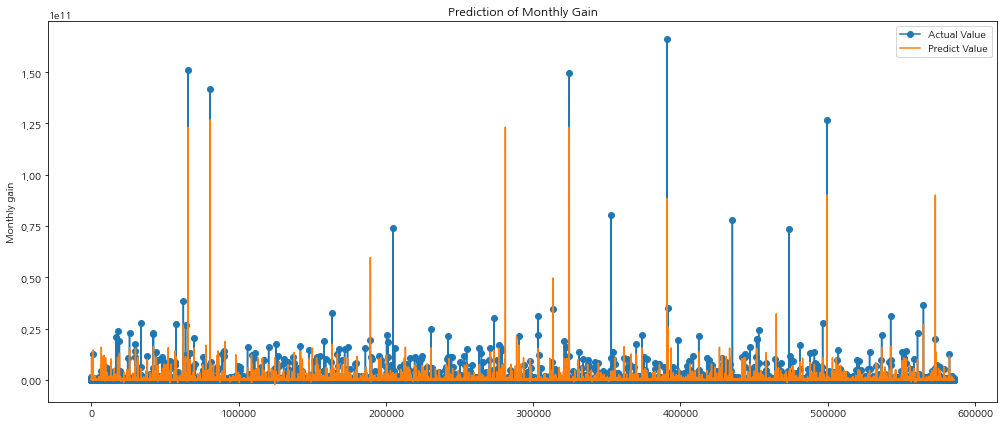

In [147]:
plt.figure(figsize=(17,7))
plt.plot(range(0, len(test_y)), test_y,'o-', label='Actual Value')
plt.plot(range(0, len(pred_xgb)), pred_lgbm, '-', label='Predict Value')
plt.title('Prediction of Monthly Gain')
plt.ylabel('Monthly gain')
plt.legend()

<AxesSubplot:>

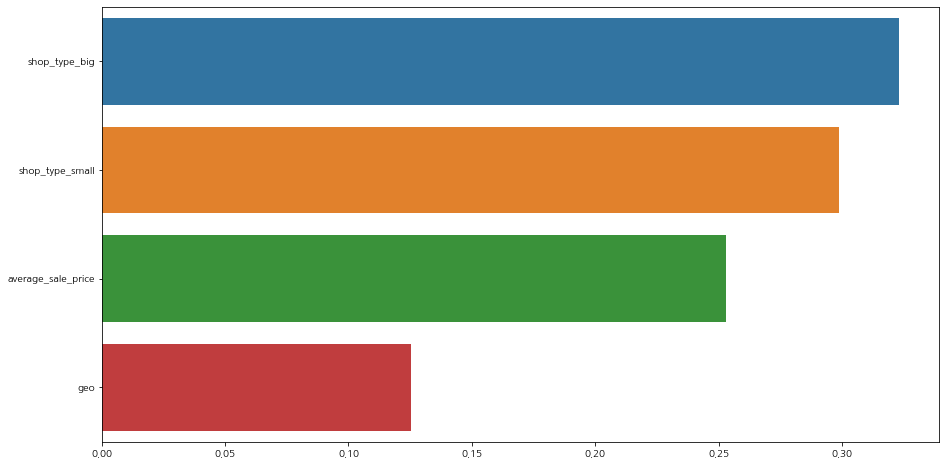

In [31]:
feature_series = pd.Series(data=model_xgb.feature_importances_, index=train_X.columns)
feature_series = feature_series.sort_values(ascending=False) 
sns.barplot(x = feature_series, y=feature_series.index)

<AxesSubplot:>

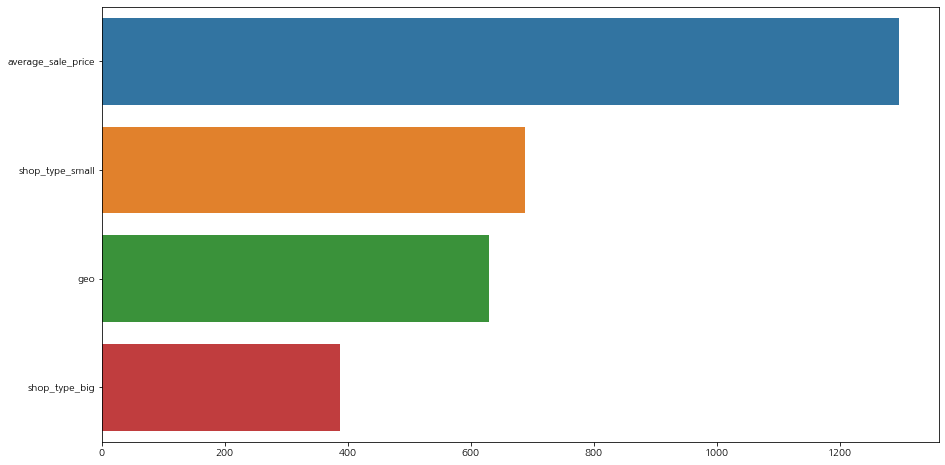

In [32]:
feature_series = pd.Series(data=model_lgbm.feature_importances_, index=train_X.columns)
feature_series = feature_series.sort_values(ascending=False) 
sns.barplot(x = feature_series, y=feature_series.index)